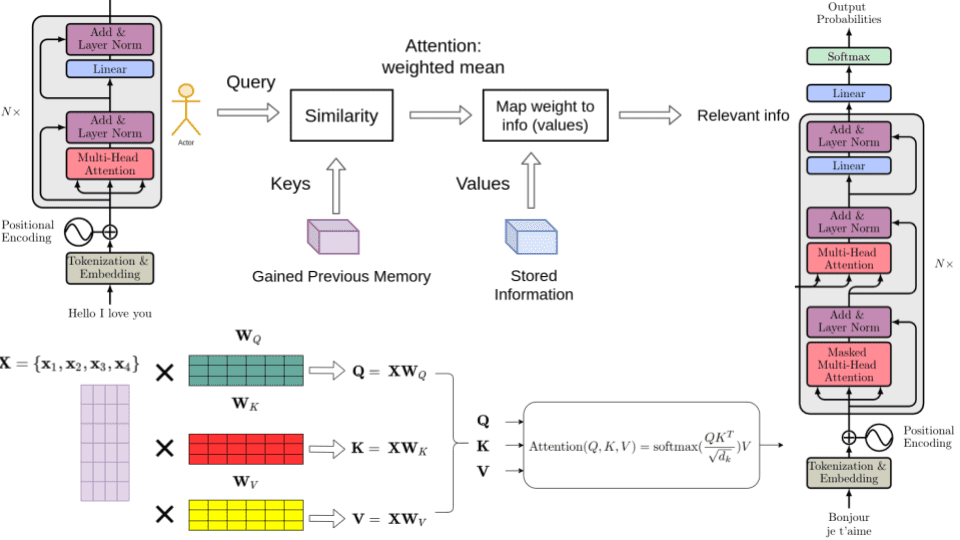

In questo tutorial spiegheremo come implementare *from scratch* i transformers. Il materiale è stato preso dal paper "Attention is all you need" e verrà utilizzato Pytorch. 


Fondamentalmente i transformers hanno un'architettura di tipo **encoder-decoder**.  Esempio più classico: un modello language translation.

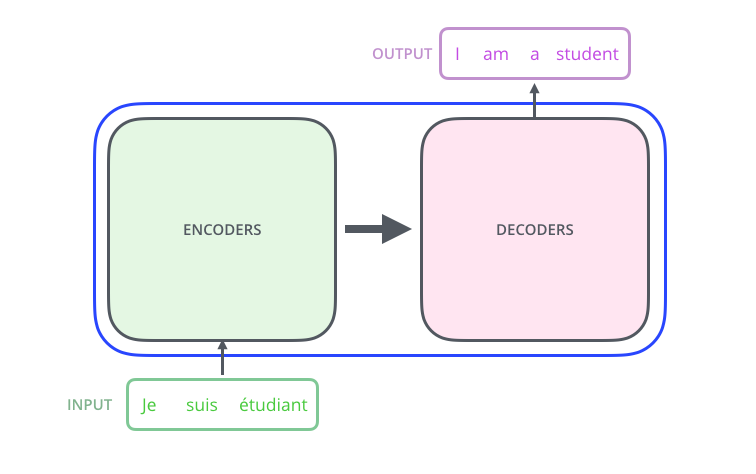

In modo più stratificato nei transformers esiste un'architettura a stack.
Questa architettura è formata da uno stack di encoder e stack of decoder

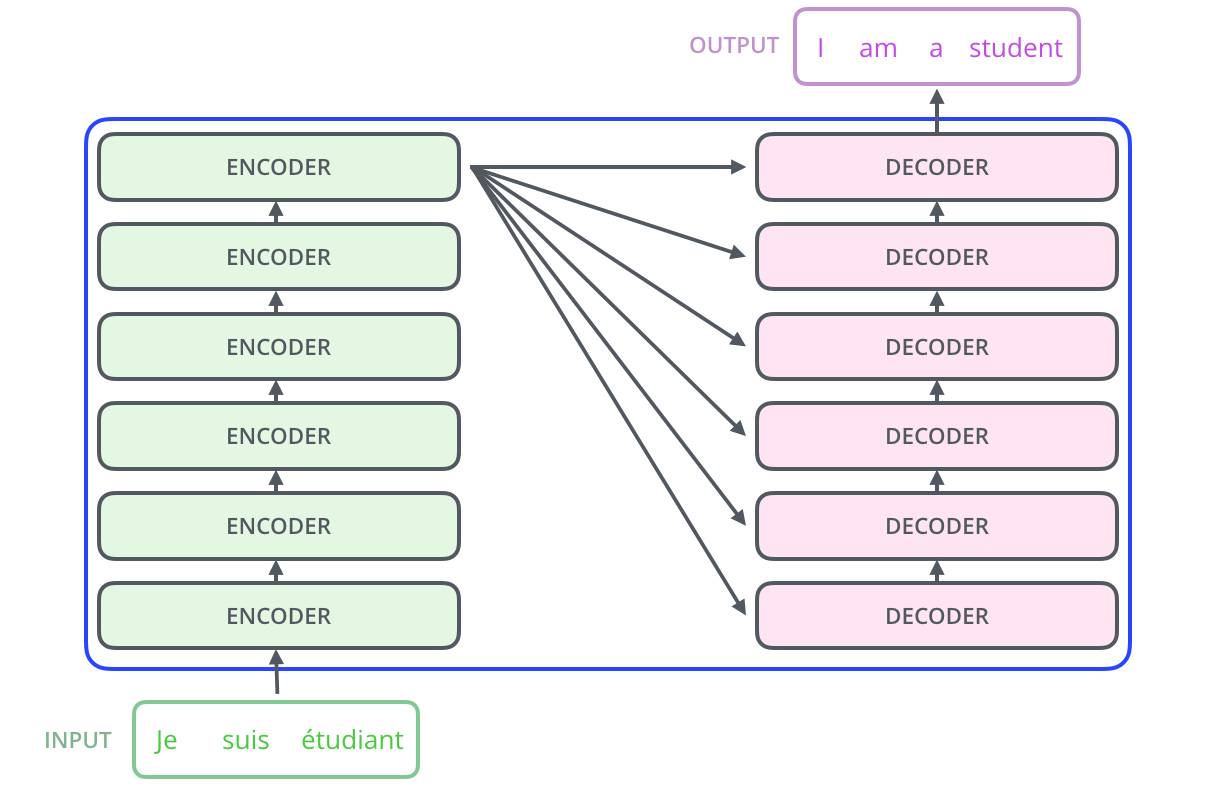

Prima di proseguire, vediamo un'immagine completa del modello di **attention**.

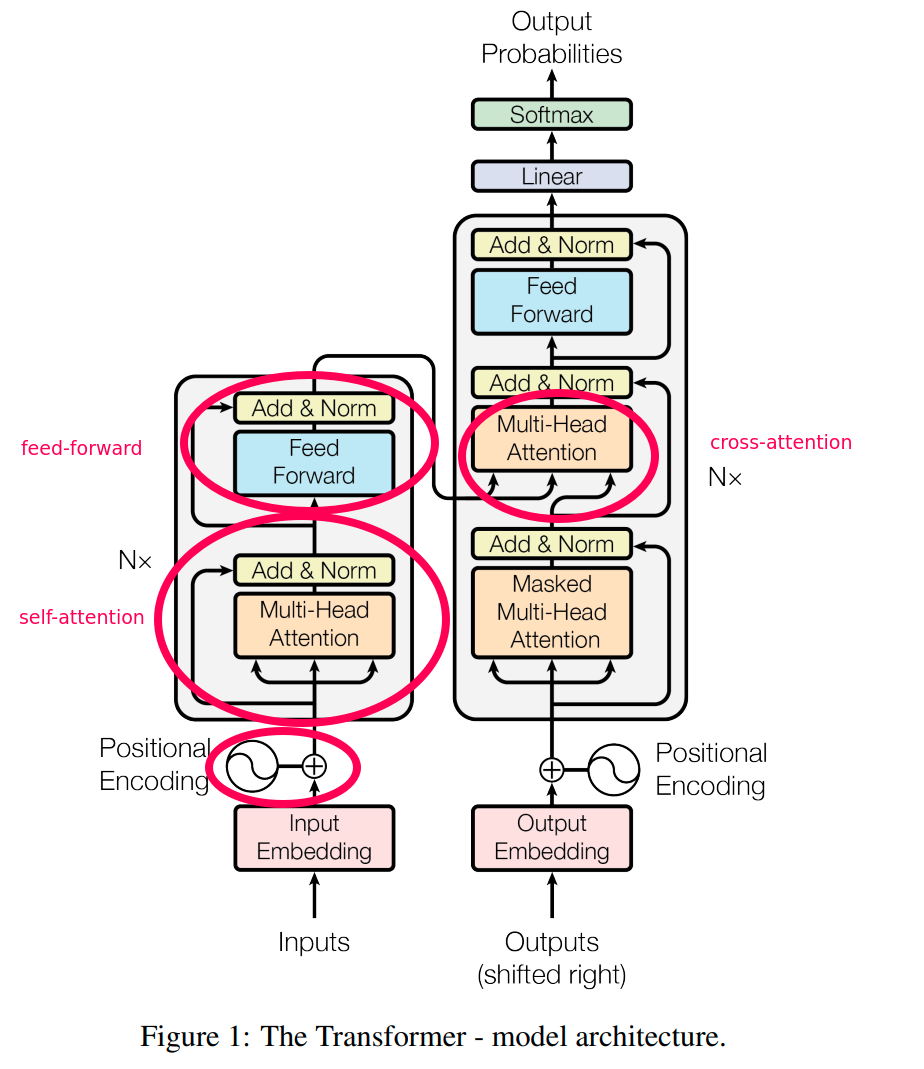

In [ ]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

# Componenti Base

## Word Embeddings

Prima di tutto, dobbiamo convertire ogni parola della sequenza di input in un Word Embedding. 

I vettori embedding creeranno rappresentazioni numeriche di ogni parola.

Supponiamo che ogni vettore di embedding sia di $512$ dimensioni e che il nostro vocabolario sia di $100$, allora la nostra matrice di embedding sarà di dimensioni $100 \times 512$. 

Queste matrici saranno apprese durante l'addestramento e durante l'inferenza ogni parola sarà mappata sul corrispondente vettore di $512$ dimensioni. Supponiamo di avere un batch di $32$ e una lunghezza di sequenza di $10$ (10 parole). 



L'output sarà $32 \times 10 \times 512$.

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

## Positional Encoding

Il passo successivo è la generazione del Positional Encoding (codifica posizionale). 
Per dare un senso alla frase, il modello deve sapere due cose su ogni parola.

*   qual è la posizione della parola nella frase?

*   che cosa significa la parola?



In "Attention is All You Need" sono state usate le seguenti funzioni per creare il Positional Encoding. 

Nei passi temporali dispari viene utilizzata una funzione coseno e nei passi temporali pari una funzione seno.


**pos:**  l'ordine nella frase

**i:**  posizione lungo la dimensione dell'embedding vector

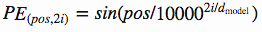



image.png

Il **Positinal embedding** genera una matrice simile alla matrice di embedding. 

Quindi creerà una matrice di dimensione lunghezza della sequenza x dimensione dell'embedding. 

Per ogni token (parola) nella sequenza, troveremo il vettore embedding di dimensione $1 \times 512$ e lo sommeremo al corrispondente vettore posizionale di dimensione $1 \times 512$ per ottenere una dimensione $1 \times 512$ per ogni parola/token.

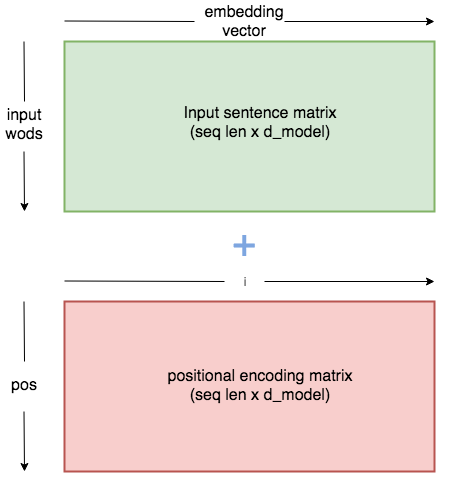

In [ ]:
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.
class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

## Self Attention

$Attention(Q,K,V) = Softmax( \frac{QK^T}{\sqrt{d_k}} ) V$

Supponiamo di avere una frase:



```
 "Il cane attraversa la strada perché ha visto la cucina"

```

 
A che cosa si riferisce? Per gli esseri umani è facile capire che si tratta del cane. Ma non per le macchine.


Mentre il modello procede con ogni parola, la self attention permette di guardare più posizioni nella sequenza di input per trovare indizi.

Verrà creato un vettore basato sulla dipendenza di ogni parola dalle altre.

**Step 1:** il primo passo per calcolare la Self Attention consiste nel creare tre vettori da ciascuno dei vettori di ingresso del codificatore (in questo caso, l'embedding di ogni parola). 

Quindi, per ogni parola, creiamo un vettore Query $Q$, un vettore Key $K$ e un vettore Value $V$. Ciascun vettore avrà una dimensione di $1 \times 64$.



Come si creano $Q$, $K$ e $V$?

Avremo una matrice di $K$, una matrice di $Q$ e una matrice di $V$ per generarli. 

Queste matrici vengono apprese durante l'addestramento.

**Step 2:** La seconda fase consiste nel calcolare il lo score di $Q \times K$


**Step 3:** si divide la matrice di uscita con la radice quadrata della *dimensione* della matrice $K$ e si applica la *Softmax* su di essa.


**Step 4:** Si moltiplica per la matrice dei valori

**Step 5:** Una volta ottenuto questo dato, lo passiamo attraverso un livello lineare. Questo costituisce l'output la multihead attention.


Poiché abbiamo una multihead attention, avremo 8 heads di self attention.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d
       
        #key,query and value matrixes    #64 x 64   
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
        
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        
        # query dimension can change in decoder during inference. 
        # so we cant take general seq_length
        seq_length_query = query.size(1)
        
        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
       
        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)   
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
       
        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
      
        
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)
 
        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64) 
        
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        
        output = self.out(concat) #(32,10,512) -> (32,10,512)
       
        return output

## Encoder

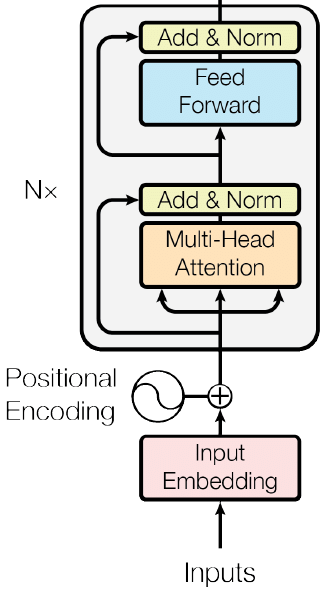

**Step 1:** L'input con (token padded corrispondenti alla frase) passa attraverso lo strato di embedding e lo strato di codifica posizionale.

**Step 2:**  Come discusso in precedenza, passa attraverso multihead attention layer che crea una matrice di rappresentazione utile come output.

**Step 3:** Poi abbiamo una normalizzazione e una connessione residua. L'uscita della multihead attention viene sommata all'ingresso e quindi normalizzata.

**Step 4:**  Successivamente abbiamo uno strato di feed forward e uno strato di normalizzazione con la connessione residua dall'ingresso (ingresso dello strato di feed forward) dove passiamo l'uscita dopo la normalizzazione e otteniamo infine l'uscita dell'encoder.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim) 
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block
        
        """
        
        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out



class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention
        
    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

## Decoder

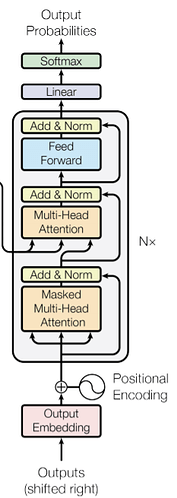

Utilizzeremo l'uscita dell'encoder per generare vettori di chiavi e valori per il decoder. 

Esistono due tipi di  multi head attention: una è l'attention del decoder e l'altra è l'attention del decoder del encoder. 

**Step 1:** Per prima cosa l'output viene passato attraverso l'embedding e la codifica posizionale per creare un vettore di embedding di dimensione $1 \times 512$ corrispondente a ciascuna parola della sequenza di destinazione.

**Step 2:** L'output di embeddig viene fatto passare attraverso uno strato di multihead attention  come in precedenza (creando matrici di chiavi, query e valori dall'input dell'obiettivo) e produce un vettore di output. Questa volta la differenza principale è che utilizziamo una mask con la multihead attention.

**mask?** La maschera viene utilizzata perché, mentre creiamo l'attention per le parole target, non abbiamo bisogno di una parola per guardare alle parole future e verificare la dipendenza. 

Poiché stiamo creando l'attention per le parole nella sequenza target, non abbiamo bisogno di una parola particolare per vedere le parole future. 



Per esempio, nella parola "sono uno studente", non abbiamo bisogno della parola "uno" per vedere la parola "studente".

**Step 3:** Come in precedenza, abbiamo uno strato add e norm in cui sommiamo l'output dell'embedding con l'attention out e lo normalizziamo.

**Step 4:** Poi c'è un'altra multihead attention e quindi un norm layer. Questa multihead attention è chiamata multihead attention encoder-decorder. Per questa multihead attention creiamo vettori chiave e valore dall'uscita dell'encoder. La query viene creata dall'uscita del precedente livello di decoder.

**Step 5:** 
Successivamente c'è uno strato di feed forward  con add e norm che è simile a quello presente nel codificatore.

**Step 6:** Infine c'è uno strato lineare con lunghezza pari al numero di parole nel corpus di destinazione totale e una funzione softmax per ottenere la probabilità di ogni parola.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)
        
    
    def forward(self, key, query, x,mask):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention 
        Returns:
           out: output of transformer block
    
        """
        
        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))
        
        out = self.transformer_block(key, query, value)

        
        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):
        
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """
            
        
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)
     
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask) 

        out = F.softmax(self.fc_out(x))

        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim:  dimension of embedding 
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        
        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask    

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)
          
        
        return out_labels
    
    def forward(self, src, trg):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
   
        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

## Test

Supponiamo di avere una sequenza di input di lunghezza 10 e una sequenza di output di lunghezza 10.

In [ ]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])

target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
model

In [ ]:
out = model(src, target)
out.shape

In [ ]:
# inference
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length, 
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
                  


src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])
trg = torch.tensor([[0]])
print(src.shape,trg.shape)
out = model.decode(src, trg)
out



---



# Attention & Self-Attention

![texto alternativo](https://miro.medium.com/max/1973/1*_92bnsMJy8Bl539G4v93yg.gif)

# Step 0. Cosa è la self-attention?

La self-attention è simile all'attention?


(Fondamentalmente condividono lo stesso concetto e molte operazioni matematiche comuni)


Un modulo di self-attention accetta n input e restituisce n output. 

Cosa succede in questo modulo? 

In parole povere, il meccanismo di self-attention consente agli input di interagire tra loro e scoprire a chi dovrebbero prestare maggiore attenzione ("attention"). 

Gli output sono aggregati di queste interazioni e punteggi di attention.

### Step 1: Input

![texto alternativo](https://miro.medium.com/max/1973/1*hmvdDXrxhJsGhOQClQdkBA.png)

In [ ]:
x = [
  [1, 0, 1, 0], # Input 1
  [0, 2, 0, 2], # Input 2
  [1, 1, 1, 1]  # Input 3
 ]
x = torch.tensor(x, dtype=torch.float32)
x

### Step 2: Weights

Ogni input deve avere le seguenti rappresentazioni: **key** (orange), **query** (red), and **value** (purple).


![texto del enlace](https://miro.medium.com/max/1975/1*VPvXYMGjv0kRuoYqgFvCag.gif)

In [ ]:
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

print("Weights for key: \n", w_key)
print("Weights for query: \n", w_query)
print("Weights for value: \n", w_value)

### Step 3: Calcolo K, Q e V

Ora che abbiamo le tre serie di pesi, otteniamo effettivamente il **key**, **query** e **value** representations per ogni input.

Keys:

```
               [0, 0, 1]
[1, 0, 1, 0]   [1, 1, 0]   [0, 1, 1]
[0, 2, 0, 2] x [0, 1, 0] = [4, 4, 0]
[1, 1, 1, 1]   [1, 1, 0]   [2, 3, 1]
```
![texto alternativo](https://miro.medium.com/max/1975/1*dr6NIaTfTxEWzxB2rc0JWg.gif)

---



Values:

```
               [0, 2, 0]
[1, 0, 1, 0]   [0, 3, 0]   [1, 2, 3] 
[0, 2, 0, 2] x [1, 0, 3] = [2, 8, 0]
[1, 1, 1, 1]   [1, 1, 0]   [2, 6, 3]
```
 ![texto alternativo](https://miro.medium.com/max/1975/1*5kqW7yEwvcC0tjDOW3Ia-A.gif)

Querys:

```
               [1, 0, 1]
[1, 0, 1, 0]   [1, 0, 0]   [1, 0, 2]
[0, 2, 0, 2] x [0, 0, 1] = [2, 2, 2]
[1, 1, 1, 1]   [0, 1, 1]   [2, 1, 3]
```
![texto alternativo](https://miro.medium.com/max/1975/1*wO_UqfkWkv3WmGQVHvrMJw.gif)

Un vettore bias può essere aggiunto al prodotto della moltiplicazione di matrici.

In [ ]:
keys = x @ w_key
querys = x @ w_query
values = x @ w_value

print("Keys: \n", keys)
# tensor([[0., 1., 1.],
#         [4., 4., 0.],
#         [2., 3., 1.]])

print("Querys: \n", querys)
# tensor([[1., 0., 2.],
#         [2., 2., 2.],
#         [2., 1., 3.]])
print("Values: \n", values)
# tensor([[1., 2., 3.],
#         [2., 8., 0.],
#         [2., 6., 3.]])

### Step 4: Calculate attention scores
![texto alternativo](https://miro.medium.com/max/1973/1*u27nhUppoWYIGkRDmYFN2A.gif)


Per ottenere gli **attention scores**, si calcola il dot product tra Input 1’s **query** (red) con **all keys** (orange)

```
            [0, 4, 2]
[1, 0, 2] x [1, 4, 3] = [2, 4, 4]
            [1, 0, 1]
```


Viene mostrata solo la query dall'Input 1. 

In seguito verrà ripetuto per le altre query.

Nota: *L'operazione di cui sopra è nota come dot product attention, una delle numerose funzioni di punteggio. Altre funzioni di partitura includono lo scaled dot product e additive/concat.*

In [ ]:
attn_scores = querys @ keys.T
print(attn_scores)

# tensor([[ 2.,  4.,  4.],  # attention scores from Query 1
#         [ 4., 16., 12.],  # attention scores from Query 2
#         [ 4., 12., 10.]]) # attention scores from Query 3

### Step 5: Calculate softmax
![texto alternativo](https://miro.medium.com/max/1973/1*jf__2D8RNCzefwS0TP1Kyg.gif)

Viene presa la **softmax** degli **attention scores** (blocchi blu).
```
softmax([2, 4, 4]) = [0.0, 0.5, 0.5]
```

In [ ]:
from torch.nn.functional import softmax

attn_scores_softmax = softmax(attn_scores, dim=-1)
print(attn_scores_softmax)
# tensor([[6.3379e-02, 4.6831e-01, 4.6831e-01],
#         [6.0337e-06, 9.8201e-01, 1.7986e-02],
#         [2.9539e-04, 8.8054e-01, 1.1917e-01]])

# For readability, approximate the above as follows
attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
attn_scores_softmax = torch.tensor(attn_scores_softmax)
print(attn_scores_softmax)

### Step 6: Multiply scores with values
![texto alternativo](https://miro.medium.com/max/1973/1*9cTaJGgXPbiJ4AOCc6QHyA.gif)

GLi score appena ottenuti sono moltiplicati per i corrispondenti **V** (blocchi viola). 

I risultati sono i famosi **weighted values**.
```
1: 0.0 * [1, 2, 3] = [0.0, 0.0, 0.0]
2: 0.5 * [2, 8, 0] = [1.0, 4.0, 0.0]
3: 0.5 * [2, 6, 3] = [1.0, 3.0, 1.5]
``` 

In [ ]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
print(weighted_values)

### Step 7: Sum weighted values
![texto alternativo](https://miro.medium.com/max/1973/1*1je5TwhVAwwnIeDFvww3ew.gif)


Tutti i **weighted values** (blocchi gialli) sono sommati (element-wise):

```
  [0.0, 0.0, 0.0]
+ [1.0, 4.0, 0.0]
+ [1.0, 3.0, 1.5]
-----------------
= [2.0, 7.0, 1.5]
```

Il vettore risultanti ```[2.0, 7.0, 1.5]``` è **Output 1**, basato sulla **query representation** dell' **Input 1** integrato con tutte le atre chiavi.

### Step 8: Repeat for Input 2 & Input 3
![texto alternativo](https://miro.medium.com/max/1973/1*G8thyDVqeD8WHim_QzjvFg.gif)


La dimensione di **query** e **key** deve essere sempre la stessa a causa della funzione del dot product score function. 

Tuttavia, la dimensione di **value** potrebbe essere diversa da **query** e **key**. 

L'output risultante seguirà di conseguenza la dimensione di **value**.*

In [ ]:
outputs = weighted_values.sum(dim=0)
print(outputs)

# tensor([[2.0000, 7.0000, 1.5000],  # Output 1
#         [2.0000, 8.0000, 0.0000],  # Output 2
#         [2.0000, 7.8000, 0.3000]]) # Output 3